In [2]:
library(ggstatsplot)
library(ggside)
library(dplyr)
library(summarytools)
library(ggfortify)
library(plyr)
library(purrr)
library(hash)
library(scales)
library(ggridges)
library(ggplot2)

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167

Registered S3 method overwritten by 'ggside':
  method from   
  +.gg   ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system2("/usr/bin/otool", c("-L", shQuote(DSO)), stdout = TRUE):
“running command ''/usr/bin/otool' -L '/Users/suzheng/opt/anaconda3/envs/r4new/lib/R/library/tcltk/libs//tcltk.so'' had status 1”
system might not have X11 capabilities; in case of errors when using dfSummary(), set st_options(use.x11 = FALSE)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and d

In [3]:
dir <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/cor_with_clinvar/anal/"
setwd(dir)
Sys.setenv("psi_fig_tables_RData_dir"="/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/fig_tables/RData")

In [4]:
col_sz <- c('#00A1D5FF','#6A6599FF','#DF8F44FF','#B24745FF','#80796BFF','#79AF97FF','#374E55FF')

In [ ]:

gene_info.stat.file = "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi/data/gene_info.exon_var_stat.Rdata"
#gene_info.stat.file = "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi/data/gene_info.path_var_stat.Rdata"


load(gene_info.stat.file)
gene_info.stat.ori <- gene_info.stat

## Read in the mean psi in each age group

In [6]:
psi_dir <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/target_gene_psi/"
skeletal_muscle_age_group_assoc.1 <- read.table(paste0(psi_dir, "/skeletal_muscle_age_group_assoc.1.tsv"))
cardiac_muscle_age_group_assoc.1 <- read.table(paste0(psi_dir, "/cardiac_muscle_age_group_assoc.1.tsv"))
skeletal_muscle_age_group_assoc.1 <- skeletal_muscle_age_group_assoc.1 %>% mutate(delta.adult.fetal=mean.adult-mean.fetal_neonatal) %>% mutate(delta.adult.pediatric=mean.adult-mean.pediatric) %>% mutate(delta.pediatric.fetal=mean.pediatric-mean.fetal_neonatal)
cardiac_muscle_age_group_assoc.1 <- cardiac_muscle_age_group_assoc.1 %>% mutate(delta.adult.fetal=mean.adult-mean.fetal_neonatal) %>% mutate(delta.adult.pediatric=mean.adult-mean.pediatric) %>% mutate(delta.pediatric.fetal=mean.pediatric-mean.fetal_neonatal)
skeletal_cardiac_stat <- full_join(skeletal_muscle_age_group_assoc.1, cardiac_muscle_age_group_assoc.1, 
                                   by=c("name"="name"),
                                   suffix = c(".skeletal", ".cardiac")
                                  )


In [7]:
colnames(skeletal_cardiac_stat)

[1] "pval.skeletal"                  "name"                          
 [3] "estimate.skeletal"              "gene.skeletal"                 
 [5] "exon_num.skeletal"              "fdr.skeletal"                  
 [7] "signif.skeletal"                "mean.fetal_neonatal.skeletal"  
 [9] "mean.pediatric.skeletal"        "mean.adult.skeletal"           
[11] "sd.fetal_neonatal.skeletal"     "sd.pediatric.skeletal"         
[13] "sd.adult.skeletal"              "delta_mean.skeletal"           
[15] "gene0.skeletal"                 "delta.adult.fetal.skeletal"    
[17] "delta.adult.pediatric.skeletal" "delta.pediatric.fetal.skeletal"
[19] "pval.cardiac"                   "estimate.cardiac"              
[21] "gene.cardiac"                   "exon_num.cardiac"              
[23] "fdr.cardiac"                    "signif.cardiac"                
[25] "mean.fetal_neonatal.cardiac"    "mean.pediatric.cardiac"        
[27] "mean.adult.cardiac"             "sd.fetal_neonatal.cardiac"     
[29] "sd.pediatric.cardiac"           "sd.adult.cardiac"              
[31] "delta_mean.cardiac"             "gene0.cardiac"                 
[33] "delta.adult.fetal.cardiac"      "delta.adult.pediatric.cardiac" 
[35] "delta.pediatric.fetal.cardiac"

In [8]:
cds_file <- "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/data/get_LRG_ENS_IDs_for_target_genes/gencode.v38.annotation.gtf.gz.NMgenes.CDS"
cds_rt <- read.csv(cds_file, sep="\t", header=F)

In [ ]:
if(FALSE){

    cds_dict <- hash()

    for(i in 1:(dim(cds_rt)[1])){

        x <- cds_rt[i,]
        start <- as.numeric(x[,3])
        end <- as.numeric(x[,4])

        sapply(start:end, function(pos){  
           key = paste(sub("chr", "", x[,1]), pos, sep=":")

           #cds_dict[[key]] <<- 1
            cds_dict[key] <<- 1
        })
    }
    is_cds_df <- map_dfr(1:nrow(gene_info.stat), function(i){
        x <- gene_info.stat[i,]
        start <- paste(x$chr, x$start, sep=":")
        mid <- paste(x$chr, as.integer((x$start + x$end)/2), sep=":")
        end <-  paste(x$chr, x$start, sep=":")
        is_cds <- has.key(start, cds_dict) & has.key(mid, cds_dict) & has.key(end, cds_dict)
        data.frame(is_cds=is_cds)
        }
    )
    gene_info.stat$is_cds <- is_cds_df$is_cds
}

In [ ]:

gene_info.stat$is_cds <- TRUE
gene_info.stat <- gene_info.stat.ori %>% filter(gnomad.syn>=1)
plots <- list()

# Create histogram plots and store them into the list
for(col_name in colnames(gene_info.stat)[-c(1:8)]) {
    # Create a data frame for ggplot
    data_to_plot <- data.frame(value = gene_info.stat[[col_name]])
    
    # Generate a ggplot object
    p <- ggplot(data_to_plot, aes(x = log10(value+1))) 

    
    # Add the plot to the list
    plots[[col_name]] <- p
}

# Save the list of plots into an RData file
save(plots, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/plots_distributions_of_variant_counts_by_exon.RData"))


In [11]:
skeletal_cardiac_stat.clinvar.ori <- inner_join(skeletal_cardiac_stat, 
                                            gene_info.stat.ori,
                                            by=c("name"="exon")
                                           )
skeletal_cardiac_stat.clinvar <- skeletal_cardiac_stat.clinvar.ori %>% filter(gnomad.syn>=1)

## Get number of genes after filtering

In [12]:
skeletal_cardiac_stat.clinvar$gene.skeletal %>% table() %>% length()

[1] 615

## Calculate the variant density normalized by either exon length or gnomAD syn variant number

In [13]:
#col_of_interest <- "clinvar.path_var"
cols_of_interest <- c("clinvar.path_var", grep("gnomad", colnames(skeletal_cardiac_stat.clinvar), value=T))
cols_of_interest <- grep("den", cols_of_interest, invert=T, value=T)
for(col_of_interest in cols_of_interest){
    skeletal_cardiac_stat.clinvar[[paste0(col_of_interest, ".den")]] <- skeletal_cardiac_stat.clinvar[[col_of_interest]]/skeletal_cardiac_stat.clinvar$length
    #skeletal_cardiac_stat.clinvar[[paste0(col_of_interest, ".den")]] <- skeletal_cardiac_stat.clinvar[[col_of_interest]]/skeletal_cardiac_stat.clinvar$gnomad.syn
}

In [14]:
write.table(skeletal_cardiac_stat.clinvar.ori, "skeletal_cardiac_stat.clinvar.ori.tsv", quote=F, sep="\t", col.names=NA)

In [15]:
cols_4_test <- grep("mean|delta|sd", colnames(skeletal_cardiac_stat.clinvar), value=T, perl=T)
cols_4_test <- grep("delta_mean", cols_4_test, value=T, invert=T)
#var_col <- "clinvar.path_var.den"

## filter by exon length, gnomad syn var number
### number of valid exons in a gene not used for filtering here, but used in corr analys below

In [16]:
exon_length_cutoff_val <- 20
gnomad.syn.cutoff_val <- 5
min_nonNA_count_in_a_gene <- 2
print("number of exons before filtering")
skeletal_cardiac_stat.clinvar %>% dim()
scsc.filt <- skeletal_cardiac_stat.clinvar %>% filter(length>=exon_length_cutoff_val & gnomad.syn>=gnomad.syn.cutoff_val)
print("number of exons after filtering")
scsc.filt %>% dim()
print("number of genes filtering")
scsc.filt$gene.skeletal %>% table() %>% dim()

[1] "number of exons before filtering"


[1] 11243    54

[1] "number of exons after filtering"


[1] 7106   54

[1] "number of genes filtering"


[1] 611

In [17]:
source("/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2021/velocityRNA/results/combined_analysis/visualize4paper/shared/shared.R")
options(repr.plot.width=7, repr.plot.height=7)
theme_Publication <- function(base_size=12, base_family=family_sz) {

      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "top",
               legend.direction = "horizontal",
               legend.key.size= unit(0.35, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(1,1,1,1),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




### corr between exon length and psi

Warning message in cor.test.default(scsc.filt$length, scsc.filt$mean.adult.skeletal, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  scsc.filt$length and scsc.filt$mean.adult.skeletal
S = 8.1134e+11, p-value = 0.9634
alternative hypothesis: true rho is not equal to 0
sample estimates:
         rho 
0.0003520537 



Warning message in cor.test.default(scsc.filt$length, scsc.filt$mean.adult.cardiac, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  scsc.filt$length and scsc.filt$mean.adult.cardiac
S = 8.0492e+11, p-value = 0.2815
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.008272198 



Warning message in plot_len_53p(skeletal_cardiac_stat.clinvar.ori %>% filter(length >= :
“NAs introduced by coercion”


Original KS Test D statistic: 0.07659574 
P-value from permutation test: 0 


Warning message in ks.test(x = scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == :
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == "5p_exons"] and scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == "3p_exons"]
D = 0.076596, p-value = 2.057e-06
alternative hypothesis: two-sided



Warning message in ks.test(x = scsc.filt.two_end_exons$mean.adult.cardiac[scsc.filt.two_end_exons$exon_group == :
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  scsc.filt.two_end_exons$mean.adult.cardiac[scsc.filt.two_end_exons$exon_group == "5p_exons"] and scsc.filt.two_end_exons$mean.adult.cardiac[scsc.filt.two_end_exons$exon_group == "3p_exons"]
D = 0.077447, p-value = 1.512e-06
alternative hypothesis: two-sided



Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


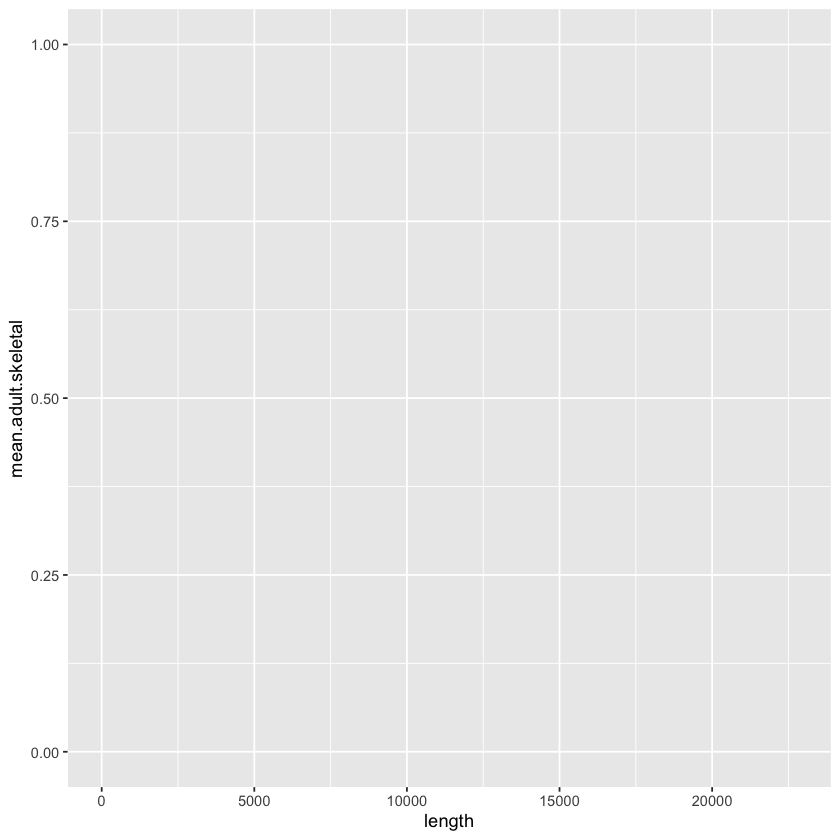

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


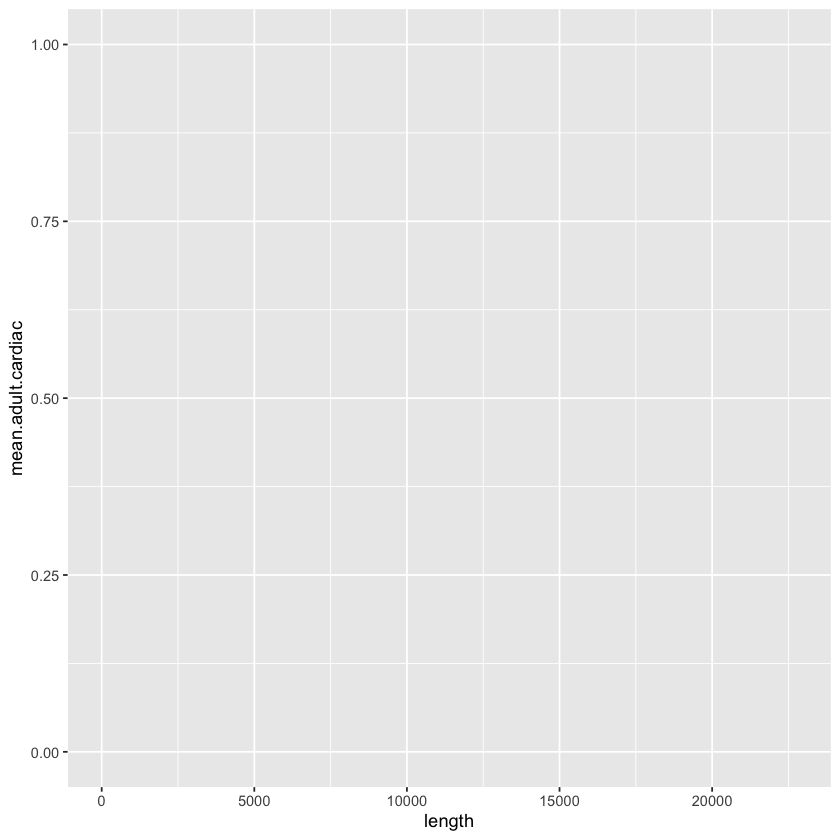

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


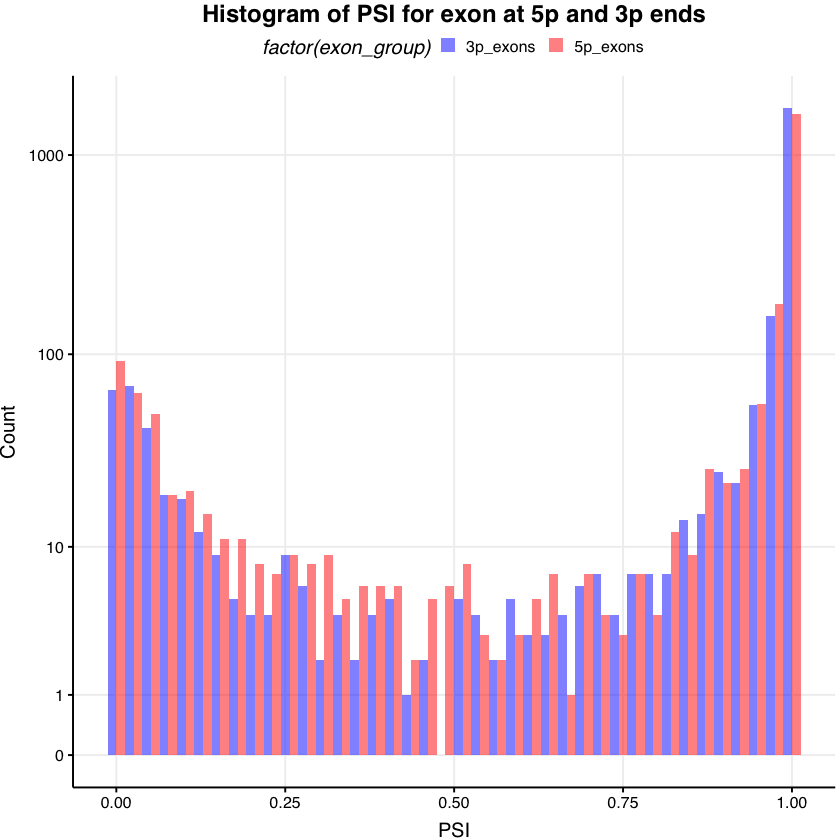

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


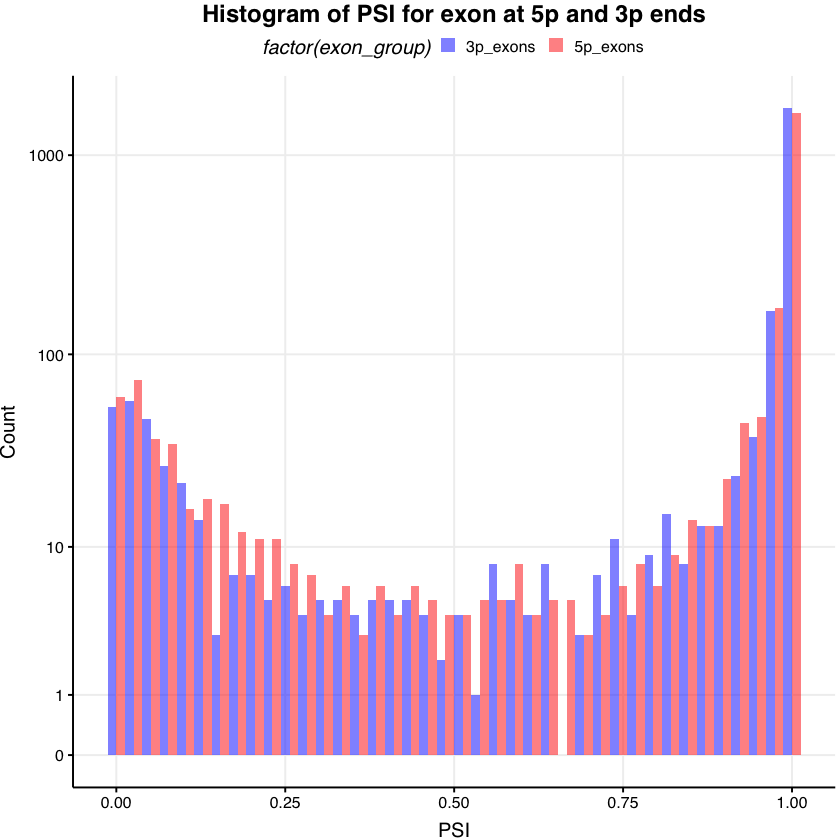

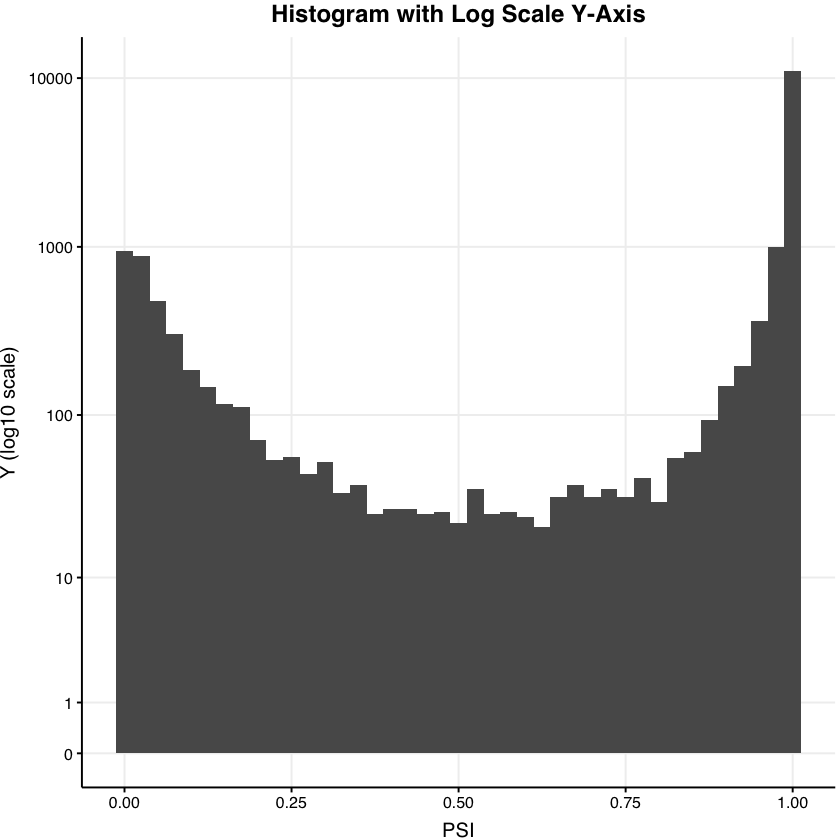

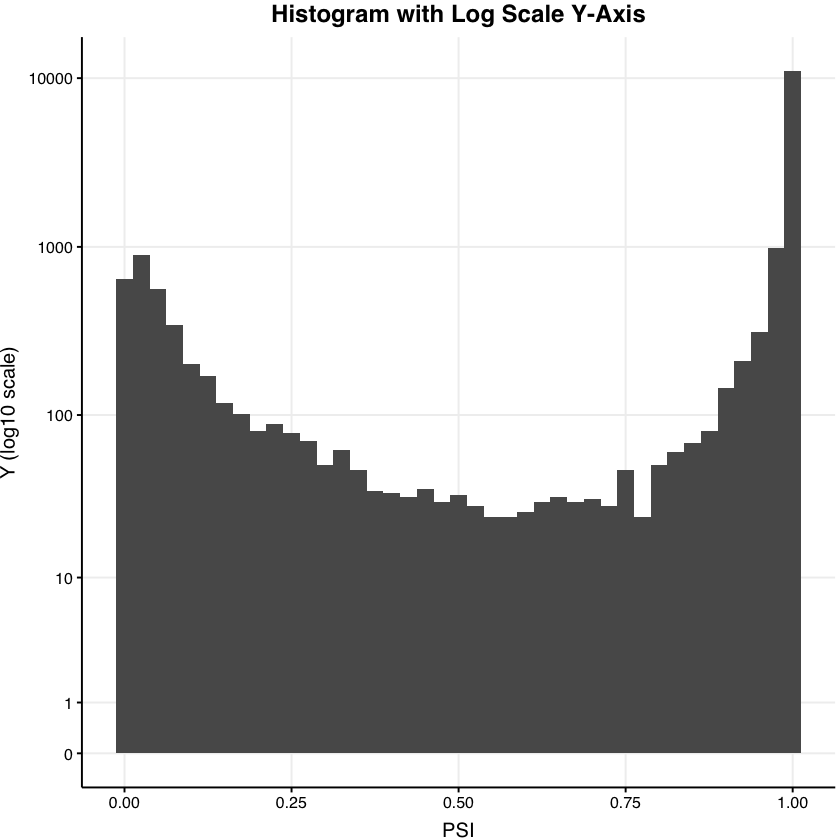

In [ ]:
add_one_trans <- function(x) log10(x + 1)
add_one_trans_obj <- scales::trans_new("add_one_trans", transform = add_one_trans, inverse = function(x) 10^x - 1)
hist_y_breaks <- c(0, 1, 10, 100, 1000, 10000)

perform_ks_with_permutation <- function(vector1, vector2, num_permutations = 100) {
  # Perform the original KS test suppressing warnings
  original_ks_test <- suppressWarnings(ks.test(vector1, vector2))
  
  # Calculate the original D statistic
  original_d <- original_ks_test$statistic
  
  # Perform permutations
  permutation_d_values <- replicate(num_permutations, {
    # Combine the vectors and shuffle
    combined <- sample(c(vector1, vector2))
    
    # Split the shuffled combined vector back into two
    perm_vector1 <- combined[1:length(vector1)]
    perm_vector2 <- combined[(length(vector1) + 1):length(combined)]
    
    # Perform KS test on the permuted vectors and get the D statistic suppressing warnings
    suppressWarnings(ks.test(perm_vector1, perm_vector2)$statistic)
  })
  
  # Calculate the p-value from permutations
  p_value_permutation <- sum(permutation_d_values >= original_d) / num_permutations
  
  # Print the results
  cat("Original KS Test D statistic:", original_d, "\n")
  cat("P-value from permutation test:", p_value_permutation, "\n")
}

                                       
plot_len_53p <- function(scsc.filt){#plot(scsc.filt$length, scsc.filt$mean.adult.skeletal)

    exon_len_psi_cor_g <- ggplot(scsc.filt, aes(x = length, y = mean.adult.skeletal)) 
#     + 
#       geom_point(size=0.2)
    cor_result <- cor.test(scsc.filt$length, scsc.filt$mean.adult.skeletal, method = "spearman")
#       geom_smooth(method = "gam", se = FALSE)  # Add a regression line without standard error

#     cor_text <- paste("Spearman rho:", round(cor_result$estimate, 4),
#                       "\nP-value:", format.pval(cor_result$p.value, digits = 3))
#     exon_len_psi_cor_g <- exon_len_psi_cor_g +
#           annotate("text", x = Inf, y = Inf, label = cor_text, hjust = 1.1, vjust = 1.1, size = 3)

    # Print the results and the plot
    print(cor_result)
    print(exon_len_psi_cor_g)
    save(exon_len_psi_cor_g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/exon_len_psi_cor_g_skeletal.RData"))
    
    
    #plot(scsc.filt$length, scsc.filt$mean.adult.skeletal)
    exon_len_psi_cor_g <- ggplot(scsc.filt, aes(x = length, y = mean.adult.cardiac))  
#       geom_point() 
    # Calculate Spearman's correlation
    cor_result <- cor.test(scsc.filt$length, scsc.filt$mean.adult.cardiac, method = "spearman")
    # Print the results
    print(cor_result)

    print(exon_len_psi_cor_g)
    save(exon_len_psi_cor_g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/exon_len_psi_cor_g_cardiac.RData"))
    
    scsc.filt$exon_num <- as.numeric(scsc.filt$exon_num.skeletal)
    genes_with_enough_exons <- names(table(scsc.filt$gene.skeletal))[table(scsc.filt$gene.skeletal) >= 10]
    scsc.filt.enough_exons_grouped <- scsc.filt %>% filter(gene.skeletal %in% genes_with_enough_exons) %>% dplyr::group_by(gene.skeletal)
    scsc.filt.3p_exons <- scsc.filt.enough_exons_grouped %>% dplyr::slice_max(exon_num, n=5) %>% dplyr::ungroup()
    scsc.filt.5p_exons <- scsc.filt.enough_exons_grouped %>% dplyr::slice_min(exon_num, n=5) %>% dplyr::ungroup()

    scsc.filt.5p_exons$exon_group <- "5p_exons"
    scsc.filt.3p_exons$exon_group <- "3p_exons"
    scsc.filt.two_end_exons <- rbind(scsc.filt.5p_exons, scsc.filt.3p_exons)
    
                                       
    exon_two_ends_g <- ggplot(scsc.filt.two_end_exons, aes(x = mean.adult.skeletal, fill = factor(exon_group))) 

    perform_ks_with_permutation(
      scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == '5p_exons'],
      scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == '3p_exons']
    )
    ks_test_result <- ks.test(
      x = scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == '5p_exons'],
      y = scsc.filt.two_end_exons$mean.adult.skeletal[scsc.filt.two_end_exons$exon_group == '3p_exons']
    )
    # Print the result of the K-S test
    print(ks_test_result)
    
    ks_test_result <- ks.test(
      x = scsc.filt.two_end_exons$mean.adult.cardiac[scsc.filt.two_end_exons$exon_group == '5p_exons'],
      y = scsc.filt.two_end_exons$mean.adult.cardiac[scsc.filt.two_end_exons$exon_group == '3p_exons']
    )
    # Print the result of the K-S test
    print(ks_test_result)
    

    save(exon_two_ends_g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/exon_two_ends_g_skeletal.RData"))


    exon_two_ends_g <- exon_two_ends_g  + 
      geom_histogram(alpha = 0.5, position = "dodge", bins = 40) +
      scale_fill_manual(values = c("blue", "red")) +
      scale_y_continuous(trans = add_one_trans_obj,
                        breaks = hist_y_breaks, # custom breaks
                         labels = hist_y_breaks)  +
      labs(title = "Histogram of PSI for exon at 5p and 3p ends", x = "PSI", y = "Count") + 
      theme_Publication()
    print(exon_two_ends_g)

    exon_two_ends_g <- ggplot(scsc.filt.two_end_exons, aes(x = mean.adult.cardiac, fill = factor(exon_group))) 

    save(exon_two_ends_g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/exon_two_ends_g_cardiac.RData"))  

    exon_two_ends_g <- exon_two_ends_g +
      geom_histogram(alpha = 0.5, position = "dodge", bins = 40) +
      scale_fill_manual(values = c("blue", "red")) +
      scale_y_continuous(trans = add_one_trans_obj,
                        breaks = hist_y_breaks, # custom breaks
                         labels = hist_y_breaks)  +
      labs(title = "Histogram of PSI for exon at 5p and 3p ends", x = "PSI", y = "Count") + 
      theme_Publication()
    print(exon_two_ends_g)
    
    skeletal_all_exon_psi_g <- ggplot(scsc.filt, aes(mean.adult.skeletal))
    save(skeletal_all_exon_psi_g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/skeletal_all_exon_psi_g.RData"))
    skeletal_all_exon_psi_g <- skeletal_all_exon_psi_g+
      geom_histogram(binwidth = 0.025) +
      scale_y_continuous(trans = add_one_trans_obj,
                        breaks = hist_y_breaks, # custom breaks
                         labels = hist_y_breaks) +
      labs(title = "Histogram with Log Scale Y-Axis", x = "PSI", y = "Y (log10 scale)") +
      theme_Publication()
    print(skeletal_all_exon_psi_g)

    cardiac_all_exon_psi_g <- ggplot(scsc.filt, aes(mean.adult.cardiac)) 
    save(cardiac_all_exon_psi_g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/cardiac_all_exon_psi_g.RData"))
    cardiac_all_exon_psi_g <- cardiac_all_exon_psi_g +
      geom_histogram(binwidth = 0.025) +
      scale_y_continuous(trans = add_one_trans_obj,
                        breaks = hist_y_breaks, # custom breaks
                         labels = hist_y_breaks) +
      labs(title = "Histogram with Log Scale Y-Axis", x = "PSI", y = "Y (log10 scale)")+
      theme_Publication()
    print(cardiac_all_exon_psi_g)
}  
plot_len_53p(skeletal_cardiac_stat.clinvar.ori %>% filter(length>=exon_length_cutoff_val))

In [19]:
colnames(skeletal_cardiac_stat.clinvar.ori)

[1] "pval.skeletal"                  "name"                          
 [3] "estimate.skeletal"              "gene.skeletal"                 
 [5] "exon_num.skeletal"              "fdr.skeletal"                  
 [7] "signif.skeletal"                "mean.fetal_neonatal.skeletal"  
 [9] "mean.pediatric.skeletal"        "mean.adult.skeletal"           
[11] "sd.fetal_neonatal.skeletal"     "sd.pediatric.skeletal"         
[13] "sd.adult.skeletal"              "delta_mean.skeletal"           
[15] "gene0.skeletal"                 "delta.adult.fetal.skeletal"    
[17] "delta.adult.pediatric.skeletal" "delta.pediatric.fetal.skeletal"
[19] "pval.cardiac"                   "estimate.cardiac"              
[21] "gene.cardiac"                   "exon_num.cardiac"              
[23] "fdr.cardiac"                    "signif.cardiac"                
[25] "mean.fetal_neonatal.cardiac"    "mean.pediatric.cardiac"        
[27] "mean.adult.cardiac"             "sd.fetal_neonatal.cardiac"     
[29] "sd.pediatric.cardiac"           "sd.adult.cardiac"              
[31] "delta_mean.cardiac"             "gene0.cardiac"                 
[33] "delta.adult.fetal.cardiac"      "delta.adult.pediatric.cardiac" 
[35] "delta.pediatric.fetal.cardiac"  "exon0"                         
[37] "gene"                           "length"                        
[39] "chr"                            "start"                         
[41] "end"                            "index"                         
[43] "clinvar.path_var"               "gnomad.missense"               
[45] "gnomad.syn"                     "gnomad.frameshift"             
[47] "gnomad.missense_inframe"        "gnomad.frameshift_stopgain"

In [20]:
cols_of_interest <- c('gene.skeletal', 'exon_num.skeletal', 'mean.fetal_neonatal.skeletal', 'mean.pediatric.skeletal', 'mean.adult.skeletal', 'mean.fetal_neonatal.cardiac', 'mean.pediatric.cardiac', 'mean.adult.cardiac', 'chr', 'start', 'end', 'clinvar.path_var', 'gnomad.missense', 'gnomad.syn', 'gnomad.frameshift_stopgain')

skeletal_cardiac_stat.clinvar.ordered <- skeletal_cardiac_stat.clinvar.ori
skeletal_cardiac_stat.clinvar.ordered$exon_num_tmp <- as.numeric(skeletal_cardiac_stat.clinvar.ordered$exon_num.skeletal)
skeletal_cardiac_stat.clinvar.ordered <- skeletal_cardiac_stat.clinvar.ordered %>%
  arrange(gene, exon_num_tmp)

skeletal_cardiac_stat.clinvar.cols_selected <- skeletal_cardiac_stat.clinvar.ordered[cols_of_interest]
colnames(skeletal_cardiac_stat.clinvar.cols_selected)[1:2] <- c("gene", "exon_num")
skeletal_cardiac_stat.clinvar.cols_selected$exon_num <- sub("^0+", "", skeletal_cardiac_stat.clinvar.cols_selected$exon_num)
write.table(skeletal_cardiac_stat.clinvar.cols_selected, 
            file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/skeletal_cardiac_stat.clinvar.cols_selected.tsv"), 
            sep = "\t", 
            col.names = TRUE, 
            row.names = FALSE, 
            quote = FALSE)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


## mark if the exon is a 5p or 3p exon

## Distribution of PSI in all exons

## calculate the mean, median, min, max and sd of psi by gene

In [21]:
scsc.filt.gene_summary <- scsc.filt %>% dplyr::group_by(gene.skeletal) %>% dplyr::summarize(
    adult.skeletal.median = median(mean.adult.skeletal, na.rm=TRUE),
    adult.skeletal.min = min(mean.adult.skeletal, na.rm=TRUE),
    adult.skeletal.max = max(mean.adult.skeletal, na.rm=TRUE),
    adult.skeletal.mean = mean(mean.adult.skeletal, na.rm=TRUE),
    adult.skeletal.sd = sd(mean.adult.skeletal, na.rm=TRUE),
    
    adult.cardiac.median = median(mean.adult.cardiac, na.rm=TRUE),
    adult.cardiac.min = min(mean.adult.cardiac, na.rm=TRUE),
    adult.cardiac.max = max(mean.adult.cardiac, na.rm=TRUE),
    adult.cardiac.mean = mean(mean.adult.cardiac, na.rm=TRUE),
    adult.cardiac.sd = sd(mean.adult.cardiac, na.rm=TRUE),
    
    adult.delta.mean = mean(abs(mean.adult.cardiac-mean.adult.skeletal)),
    adult.delta.median = median(abs(mean.adult.cardiac-mean.adult.skeletal))
    
)
names(scsc.filt.gene_summary)

[1] "gene.skeletal"         "adult.skeletal.median" "adult.skeletal.min"   
 [4] "adult.skeletal.max"    "adult.skeletal.mean"   "adult.skeletal.sd"    
 [7] "adult.cardiac.median"  "adult.cardiac.min"     "adult.cardiac.max"    
[10] "adult.cardiac.mean"    "adult.cardiac.sd"      "adult.delta.mean"     
[13] "adult.delta.median"

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


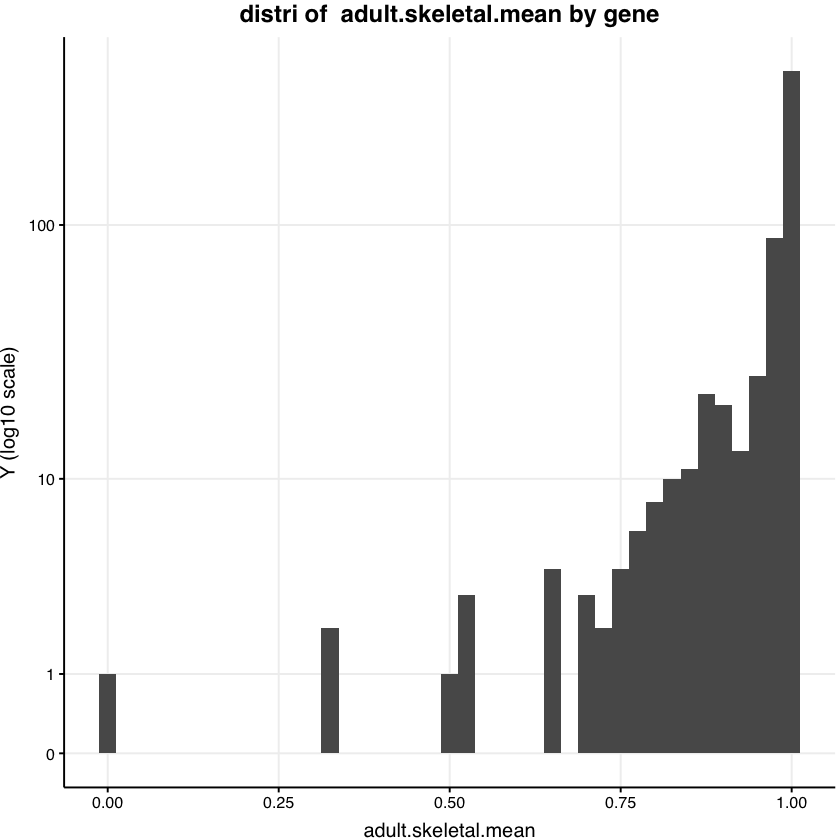

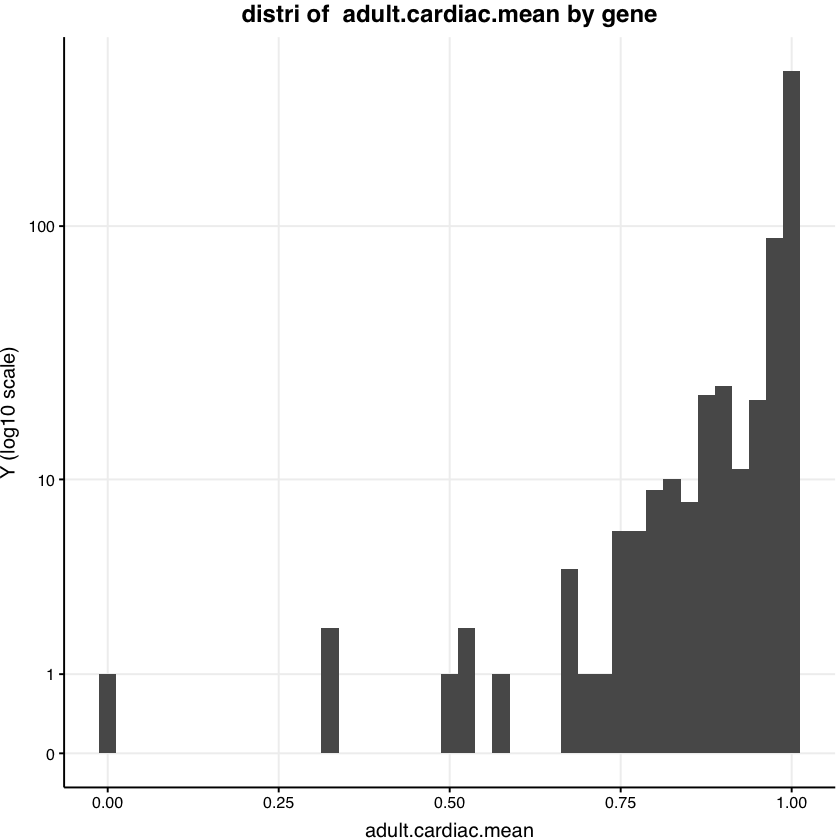

In [22]:
#for (col in names(scsc.filt.gene_summary)[-1]) {
plot_one_grouped_by_gene_col <- function(col){
    g <- ggplot(scsc.filt.gene_summary, aes_string(col)) 
    save(g, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/distri_of.", col, "by_gene", ".RData"))
    g <- g +
    geom_histogram(binwidth = 0.025) +
    scale_y_continuous(trans = add_one_trans_obj,
                    breaks = hist_y_breaks, # custom breaks
                     labels = hist_y_breaks) +
    labs(title = paste("distri of ", col, "by gene"), x = col, y = "Y (log10 scale)") +
    theme_Publication()
    g
    #scale_y_log10() +
}

skeletal_mean_by_gene_g <- plot_one_grouped_by_gene_col('adult.skeletal.mean')
cardiac_mean_by_gene_g <- plot_one_grouped_by_gene_col('adult.cardiac.mean')
adult.delta.mean_g <- plot_one_grouped_by_gene_col('adult.delta.mean')
print(skeletal_mean_by_gene_g)
print(cardiac_mean_by_gene_g)

## Visualize corr between psi and var number and density in clinvar and gnomad

In [ ]:
#apply(skeletal_cardiac_stat.clinvar[,cols_4_test], 2, function(x){median(x,na.rm=T)}) %>% min()
#skeletal_cardiac_stat.clinvar %>% colnames()
#skeletal_cardiac_stat.clinvar %>% dim()

plotc = function(x1,x2,
                   ylim=c(min(x2, na.rm=T),max(x2, na.rm=T)),
                   xlim=c(min(x1, na.rm=T),max(x1, na.rm=T)),
                   xlab="",ylab="",main="", col="black", pch=20) {
    x2 <- log10(x2+1)
    df <- data.frame(x1,x2)
    x <- densCols(x1,x2, colramp=colorRampPalette(c("black", "white")))
    df$dens <- col2rgb(x)[1,] + 1L
    cols <-  colorRampPalette(c("#000099", "#00FEFF", "#45FE4F","#FCFF00", "#FF9400", "#FF3100"))(256)
    df$col <- cols[df$dens]
    plot(x2~x1, data=df[order(df$dens),], 
         ylim=ylim,xlim=xlim,pch=pch,col=col,
         cex=1,xlab=xlab,ylab=paste(ylab, "(log10)"),
         main=main)
}

# Define the function
create_boxplot_with_summary <- function(data, var_col, group_col, main_text) {
  
  # Define a function to calculate confidence interval
  mean_ci <- function(x, conf = 0.95) {
    se <- sd(x) / sqrt(length(x))
    alpha <- 1 - conf
    mean(x) + se * qt(c(alpha / 2, 1 - alpha / 2), length(x) - 1)
  }

  # Split the data by group
  split_data <- split(data[[var_col]], data[[group_col]])

  # Calculate the mean and confidence intervals for each group
  mean_var <- lapply(split_data, mean, na.rm = TRUE)
  ci_var <- lapply(split_data, mean_ci)

  # Conduct Wilcoxon test and obtain p-value
  wilcox_test <- wilcox.test(data[[var_col]] ~ data[[group_col]])
  p_value <- wilcox_test$p.value

  # Calculate the ratio of means
  mean_ratio <- as.numeric(mean_var[[1]]) / as.numeric(mean_var[[2]])

  # Create the boxplot
  boxplot_obj <- boxplot(data[[var_col]] ~ data[[group_col]], 
                         outline = FALSE, 
                         main = main_text)

  # Add the statistical summary to the plot
  text(x = 1.5, 
       y = max(boxplot_obj$stats, na.rm = TRUE) * 0.5, 
       labels = paste0("p = ", format(p_value, digits = 2),
                       "\nGroup A: Mean = ", round(as.numeric(mean_var[[1]]), 3), 
                       ", 95% CI = (", round(ci_var[[1]][1], 3), ", ", round(ci_var[[1]][2], 3), ")",
                       "\nGroup B: Mean = ", round(as.numeric(mean_var[[2]]), 3), 
                       ", 95% CI = (", round(ci_var[[2]][1], 3), ", ", round(ci_var[[2]][2], 3), ")",
                       "\nRatio of means (A/B) = ", round(mean_ratio, 3)))
}

# Use the function



plot_all_genes <- function(psi_col, var_col, psi_metric_cutoff=0.8, var_metric_cutoff=0.05){
    psi_name <- sub("mean.", "", psi_col)
    #log10(scsc.filt[[var_col]]+1),
    #ylab=paste(var_col, "(log10)"),
    main_text = paste(psi_name, var_col, sep="\n") %>% sub(".den", "", .) %>% gsub("\\.", " ", .)
    plot(scsc.filt[[psi_col]], 
         scsc.filt[[var_col]],
         xlim=c(0,1),
         ylab=paste(var_col, ""),
         xlab=paste("Exon usage in", psi_name),
         main=main_text,
         pch=20,
         col=col_sz[2]
         )
    #plot(density(scsc.filt[scsc.filt[[var_col]]==0, psi_col] %>% na.omit()), 
    #     col="green", main=main_text, ylab=paste(var_col, ""),
    #     xlab=paste("Exon usage in", psi_name), log = "y")
    #lines(density(scsc.filt[scsc.filt[[var_col]]>0, psi_col] %>% na.omit()), col="red")
    exon_path_var <- scsc.filt[c(psi_col, var_col)]
    exon_path_var$psi <- exon_path_var[,1] > psi_metric_cutoff
    exon_path_var$path_var <- exon_path_var[,2] > var_metric_cutoff
    #exon_path_var[,c("psi", "path_var")]
    combination_counts <- table(exon_path_var$psi, exon_path_var$path_var)
    # Add headers to the table
    colnames(combination_counts) <- paste("high.var =", colnames(combination_counts))
    rownames(combination_counts) <- paste("high.psi =", rownames(combination_counts))
    # Print the combination_counts table
    print(c(psi_col, var_col))
    print(combination_counts)
    fisher.test(combination_counts)
    #exon_path_var <- exon_path_var[exon_path_var[,2]!=0, ]
    colnames(exon_path_var)[2] <- "var"
    create_boxplot_with_summary(exon_path_var, "var", "psi", main_text)
}
pdf("plots_all_genes_psi_var_cor.pdf", width=10, height=26)
par(mfcol=c(6,2), cex=0.95)
plot_all_genes("mean.fetal_neonatal.skeletal", "clinvar.path_var.den")
plot_all_genes("mean.pediatric.skeletal", "clinvar.path_var.den")
plot_all_genes("mean.adult.skeletal", "clinvar.path_var.den")
plot_all_genes("mean.fetal_neonatal.cardiac", "clinvar.path_var.den")
plot_all_genes("mean.pediatric.cardiac", "clinvar.path_var.den")
plot_all_genes("mean.adult.cardiac", "clinvar.path_var.den")
plot_all_genes("mean.adult.skeletal", "gnomad.syn.den")
plot_all_genes("mean.adult.skeletal", "gnomad.missense.den")
plot_all_genes("mean.adult.skeletal", "gnomad.frameshift_stopgain.den")

plot_all_genes("mean.adult.cardiac", "gnomad.syn.den")
plot_all_genes("mean.adult.cardiac", "gnomad.missense.den")
plot_all_genes("mean.adult.cardiac", "gnomad.frameshift_stopgain.den")

dev.off()



[1] "mean.fetal_neonatal.skeletal" "clinvar.path_var.den"        
                  
                   high.var = FALSE high.var = TRUE
  high.psi = FALSE              269              14
  high.psi = TRUE              6045             733
[1] "mean.pediatric.skeletal" "clinvar.path_var.den"   
                  
                   high.var = FALSE high.var = TRUE
  high.psi = FALSE              268               9
  high.psi = TRUE              6056             746
[1] "mean.adult.skeletal"  "clinvar.path_var.den"
                  
                   high.var = FALSE high.var = TRUE
  high.psi = FALSE              271              10
  high.psi = TRUE              6069             756
[1] "mean.fetal_neonatal.cardiac" "clinvar.path_var.den"       
                  
                   high.var = FALSE high.var = TRUE
  high.psi = FALSE              317              11
  high.psi = TRUE              6016             755
[1] "mean.pediatric.cardiac" "clinvar.path_var.den"  
          

pdf 
  2

In [ ]:
library(ggplot2)
library(tidyr)
library(patchwork)

plot_boxplots_for_4_var_metrics <- function(psi_metric_cutoff=0.8, psi_col_name="mean.adult.skeletal"){
    # Subset the data into two groups based on "mean.adult.cardiac" value
    group1 <- scsc.filt[scsc.filt[[psi_col_name]] <= psi_metric_cutoff, ]
    group2 <- scsc.filt[scsc.filt[[psi_col_name]] > psi_metric_cutoff, ]
    
    # Create a new column to indicate the groups
    group_name_legend1 <- paste("PSI <=",psi_metric_cutoff)
    group_name_legend2 <- paste("PSI >",psi_metric_cutoff)
    xlab_for_plot <- "Exon PSI"
    is_sd <- grepl("sd", psi_col_name)
    if(is_sd){
        group_name_legend1 <- paste("s.d <=",psi_metric_cutoff)
        group_name_legend2 <- paste("s.d. >",psi_metric_cutoff)
        xlab_for_plot <- "s.d. exon PSI"
    }
    group_name1 <- paste0("<= ",psi_metric_cutoff)
    group_name2 <- paste0("> ",psi_metric_cutoff)
    group1$Group <- factor(group_name1, levels = c(group_name1, group_name2))
    group2$Group <- factor(group_name2, levels = c(group_name1, group_name2))

    # Calculate the sample sizes for each group
    n_group1 <- nrow(group1)
    n_group2 <- nrow(group2)
    
    # Combine the two groups into a single data frame
    combined_data <- rbind(group1, group2)

    # Create a list to store the individual plots
    plots <- list()

    # Iterate over each variable
    variables <- c("clinvar.path_var.den", "gnomad.syn.den", "gnomad.missense.den", "gnomad.frameshift_stopgain.den")
    var_group_names <- c("P/LP variants\nfrom ClinVar",
                         "Synonymous variants\nfrom gnomAD",
                         "Missense variants\nfrom gnomAD",
                         "Frameshift and nonsense\nvariants from gnomAD")
    for (i in 1:length(variables)) {
      variable <- variables[i]

      # Calculate y-axis limits without outliers
      values <- combined_data[[variable]]
      Q1 <- quantile(values, 0.25, na.rm = TRUE)
      Q3 <- quantile(values, 0.75, na.rm = TRUE)
      IQR <- Q3 - Q1
      lower_limit <- Q1 - 1.5 * IQR
      upper_limit <- Q3 + 1.5 * IQR
      filtered_values <- values[values >= lower_limit & values <= upper_limit]
      y_axis_limits <- range(filtered_values, na.rm = TRUE)
      y_axis_limits[1] <- 0
      if(i == 1 & !is_sd){
          #y_axis_limits <- c(0, 0.046)
          y_axis_limits[2] <- y_axis_limits[2] * 1.2
      }
      if(i == 4 & !is_sd){
          #y_axis_limits <- c(0, 0.04)
          y_axis_limits[2] <- y_axis_limits[2] * 1.5
      }
      p_value <- wilcox.test(values ~ Group, data = combined_data)$p.value
      significance_level <- ifelse(p_value < 1e-6, "***",
                                   ifelse(p_value < 1e-3, "**",
                                          ifelse(p_value < 0.05, "*", "")))
      print(p_value)
      # Create a separate plot for each variable
      plot <- ggplot(combined_data, aes(x = Group, y = !!sym(variable), fill = Group)) 
      
      plot <- plot  +
        geom_boxplot(outlier.shape = NA) +
        labs(x = xlab_for_plot, y = ifelse(i == 1, "Variant density by exon", "")) +
        ggtitle(var_group_names[i]) +
        scale_fill_manual(values = c(col_sz[1], col_sz[4]),
                          breaks = c(group_name1, group_name2),
                          labels = c(group_name_legend1, group_name_legend2)) +
        coord_cartesian(ylim = y_axis_limits) +
        theme_bw() +
        theme(plot.title = element_text(hjust = 0.5, lineheight = 1.2, size = 7.4, face = "bold"),
              axis.title.x = element_text(size = 8, face = "bold"), 
              axis.title.y = element_text(size = 8, face = "bold"),
              axis.text.y = element_text(margin = margin(t = 0, r = 1, b = 0, l = 2), face = "bold"),
              plot.margin = margin(2, 0, 2, 0),
             axis.text.x = element_text(size = 8, margin = margin(t = 1, r = 0, b = 2, l = 0), face = "bold"),
             legend.text = element_text(size = 8),
             legend.title = element_text(size = 8.5)
             ) +
        annotate("text", x = 1.5, y = y_axis_limits[2]*0.9, label = significance_level, size = 3.5, vjust = 0)
        plots[[i]] <- plot  
      # Store the plot in the list
      
    }
    save(plots, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/boxplots_var_density_in_diff_psi.", psi_col_name, ".RData"))
    
    # Arrange the plots in a single row and add the legend to the last plot
    combined_plots <- plots[[1]] + plots[[2]] + plots[[3]] + plots[[4]] +
      plot_layout(ncol = 4, widths = c(1, 1, 1, 1), guides = "collect")

    # Output the combined plots to a PDF file
    ggsave(paste0("boxplots_var_density_in_diff_psi.", psi_col_name, ".combined_plots.pdf"), combined_plots, width = 7.4, height = 2.5)
    # Display the combined plots
    #print(combined_plots)
}
psi_metric_cutoff <- 0.8
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=psi_metric_cutoff, psi_col_name="mean.fetal_neonatal.skeletal")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=psi_metric_cutoff, psi_col_name="mean.pediatric.skeletal")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=psi_metric_cutoff, psi_col_name="mean.adult.skeletal")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=psi_metric_cutoff, psi_col_name="mean.fetal_neonatal.cardiac")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=psi_metric_cutoff, psi_col_name="mean.pediatric.cardiac")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=psi_metric_cutoff, psi_col_name="mean.adult.cardiac")


[1] 3.384694e-18
[1] 0.06351599
[1] 0.03206538
[1] 1.001878e-22


Warning message:
“Removed 90 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 90 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 90 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 90 rows containing non-finite values (stat_boxplot).”


[1] 1.989822e-22
[1] 0.01045796
[1] 0.08054051
[1] 1.46817e-20


Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 54 rows containing non-finite values (stat_boxplot).”


[1] 8.952666e-25
[1] 0.003137341
[1] 0.4360128
[1] 1.667117e-21
[1] 1.04682e-21
[1] 2.437735e-05
[1] 0.0128131
[1] 4.966054e-17


Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 14 rows containing non-finite values (stat_boxplot).”


[1] 1.507577e-24
[1] 2.027331e-07
[1] 0.00766767
[1] 4.573618e-11


Warning message:
“Removed 530 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 530 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 530 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 530 rows containing non-finite values (stat_boxplot).”


[1] 7.300885e-25
[1] 3.04951e-06
[1] 0.02354059
[1] 1.937094e-17


In [25]:

var_metric_cutoff <- 0.07
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=var_metric_cutoff, psi_col_name="sd.fetal_neonatal.skeletal")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=var_metric_cutoff, psi_col_name="sd.pediatric.skeletal")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=var_metric_cutoff, psi_col_name="sd.adult.skeletal")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=var_metric_cutoff, psi_col_name="sd.fetal_neonatal.cardiac")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=var_metric_cutoff, psi_col_name="sd.pediatric.cardiac")
plot_boxplots_for_4_var_metrics(psi_metric_cutoff=var_metric_cutoff, psi_col_name="sd.adult.cardiac")

[1] 0.004792549
[1] 0.01567391
[1] 5.460739e-07
[1] 1.821272e-10


Warning message:
“Removed 252 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 252 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 252 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 252 rows containing non-finite values (stat_boxplot).”


[1] 0.0002875357
[1] 0.3029892
[1] 0.01241307
[1] 1.203236e-10


Warning message:
“Removed 138 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 138 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 138 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 138 rows containing non-finite values (stat_boxplot).”


[1] 0.001081373
[1] 0.8736997
[1] 0.01837238
[1] 1.07905e-17
[1] 2.655594e-08
[1] 0.286492
[1] 4.296896e-05
[1] 4.477371e-08


Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 22 rows containing non-finite values (stat_boxplot).”


[1] 0.4840352
[1] 1.112342e-07
[1] 2.006191e-06
[1] 3.744945e-07


Warning message:
“Removed 764 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 764 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 764 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 764 rows containing non-finite values (stat_boxplot).”


[1] 7.595267e-09
[1] 0.001509299
[1] 4.797371e-05
[1] 1.48782e-10


In [ ]:
getwd()

## Generate waterfall graph

#### get the min psi of exons carrying pathogenic variants for each gene

In [ ]:
#gene_val is gene symbol, so the function deal with only one gene at a time
#var_col is something like clinvar.path_var.den, which is used for determination of whether is exon is pathogenic or not
#cols_4_test in the function is the mean, sd, delta of psi in diff age groups
#the function will get the min psi for each metric of psi in cols_4_test
get_cor_test_res_one_gene_all_cols <- function(gene_val, 
                                               var_col, 
                                               plot=F, 
                                               exon_len_cutoff=exon_length_cutoff_val,
                                               gnomad.syn.cutoff=gnomad.syn.cutoff_val,
                                               min_nonNA_count=min_nonNA_count_in_a_gene
                                              ){

    #get the data of a single gene
    #remove exon with gnomAD synon variant < gnomad.syn.cutoff
    #remove exon with length < exon_length_cutoff_val

    gene.df <- skeletal_cardiac_stat.clinvar %>% filter(gnomad.syn >= gnomad.syn.cutoff & gene==gene_val & length>=exon_len_cutoff )
    #need to have at least some number exons with non-NA PSI, same for variant den
    qc_data_for_min <- function(x, min_nonNA_count=min_nonNA_count_in_a_gene){
        sum(!is.na(x))>=min_nonNA_count
    }
    get_min_usage_of_path_exon <- function(col){
        min_psi <- NA
        min_psi_path_exon <- NA
        if(qc_data_for_min(gene.df[[col]]) & qc_data_for_min(gene.df[[var_col]])){
            min_psi <- min(gene.df[[col]], na.rm=T)
            #make it work even we are looking at den data
            psi_of_pathogenic_exons <- gene.df[gene.df[[var_col]]>1e-10, col]
            if(qc_data_for_min(psi_of_pathogenic_exons, 1)){
                min_psi_path_exon <- min(psi_of_pathogenic_exons, na.rm=T)
            }
        }
        data.frame(min_psi=min_psi, min_psi_path_exon=min_psi_path_exon)
    }
    if(plot){pdf(paste0("plot_by_gene/cor_exon_usage_features.vs.", var_col, ".in.", gene_val, ".pdf"), width=10, height=10)
            par(mfrow=c(3,3))
            }
    #cor_res.one_gene <- map_dfr(cols_4_test, get_cor_test_res_one_col)
    cor_res.one_gene <- map_dfr(cols_4_test, get_min_usage_of_path_exon)
    if(plot){dev.off()}
    rownames(cor_res.one_gene) <- cols_4_test
    colnames(cor_res.one_gene) <- paste(colnames(cor_res.one_gene), gene_val, sep=".")
    cor_res.one_gene
}
#e.g.
#x <- "clinvar.path_var"
#var_col <- paste0(x, ".den")
#get_cor_test_res_one_gene_all_cols("TTN", var_col, only_cds=TRUE)

In [60]:
#map_dfc map each gene to get_min_usage_of_path_exon
cal_cor_one_var_group_vs_all_exon_groups <- function(x){
    var_col <- paste0(x, ".den")
    #print(var_col)
    map_dfc(unique(skeletal_cardiac_stat.clinvar$gene), .f=get_cor_test_res_one_gene_all_cols, var_col=var_col, plot=F)
}

In [61]:
clinvar.path_var.min_psi.df <- cal_cor_one_var_group_vs_all_exon_groups("clinvar.path_var") 

In [62]:
#process the matrix to make it ready for visualization
clinvar.path_var.min_psi.for_plot <- clinvar.path_var.min_psi.df %>% t() %>% na.omit() %>% as.data.frame()
write.table(clinvar.path_var.min_psi.for_plot, file="clinvar.path_var_exon.min_psi.df.txt", sep="\t", quote=F, col.names=NA)
getwd()
min_type_gene <- clinvar.path_var.min_psi.for_plot %>% rownames() %>% 
map_dfr(function(x){
    data.frame(type = strsplit(x, "\\.")[[1]][1], 
               gene=strsplit(x, "\\.")[[1]][2])
})
clinvar.path_var.min_psi.for_plot <- cbind(min_type_gene, clinvar.path_var.min_psi.for_plot)
clinvar.path_var.min_psi_only <- clinvar.path_var.min_psi.for_plot %>% filter(type!="min_psi_path_exon")
rownames(clinvar.path_var.min_psi_only) <- clinvar.path_var.min_psi_only$gene
clinvar.path_var.min_psi_path_exon_only <- clinvar.path_var.min_psi.for_plot %>% filter(type=="min_psi_path_exon")
rownames(clinvar.path_var.min_psi_path_exon_only) <- clinvar.path_var.min_psi_path_exon_only$gene
clinvar.path_var.min_psi_only_gene_matched <- clinvar.path_var.min_psi_only[rownames(clinvar.path_var.min_psi_path_exon_only), ]


[1] "/Users/suzheng/Documents/suzheng/UNSW/UNSWTasks/2022/psi_calculation/results/genomewide_PSI/psi_quanti/cor_with_clinvar/anal"

In [63]:
## clinvar.path_var.min_psi_only_gene_matched is the min psi for all exons in the gene
## clinvar.path_var.min_psi_path_exon_onlyis the min psi for pathogenic variant containing exons in the gene
## they have the same shape, and the rows of genes match

In [64]:
colnames(clinvar.path_var.min_psi_only_gene_matched)

[1] "type"                           "gene"                          
 [3] "mean.fetal_neonatal.skeletal"   "mean.pediatric.skeletal"       
 [5] "mean.adult.skeletal"            "sd.fetal_neonatal.skeletal"    
 [7] "sd.pediatric.skeletal"          "sd.adult.skeletal"             
 [9] "delta.adult.fetal.skeletal"     "delta.adult.pediatric.skeletal"
[11] "delta.pediatric.fetal.skeletal" "mean.fetal_neonatal.cardiac"   
[13] "mean.pediatric.cardiac"         "mean.adult.cardiac"            
[15] "sd.fetal_neonatal.cardiac"      "sd.pediatric.cardiac"          
[17] "sd.adult.cardiac"               "delta.adult.fetal.cardiac"     
[19] "delta.adult.pediatric.cardiac"  "delta.pediatric.fetal.cardiac"

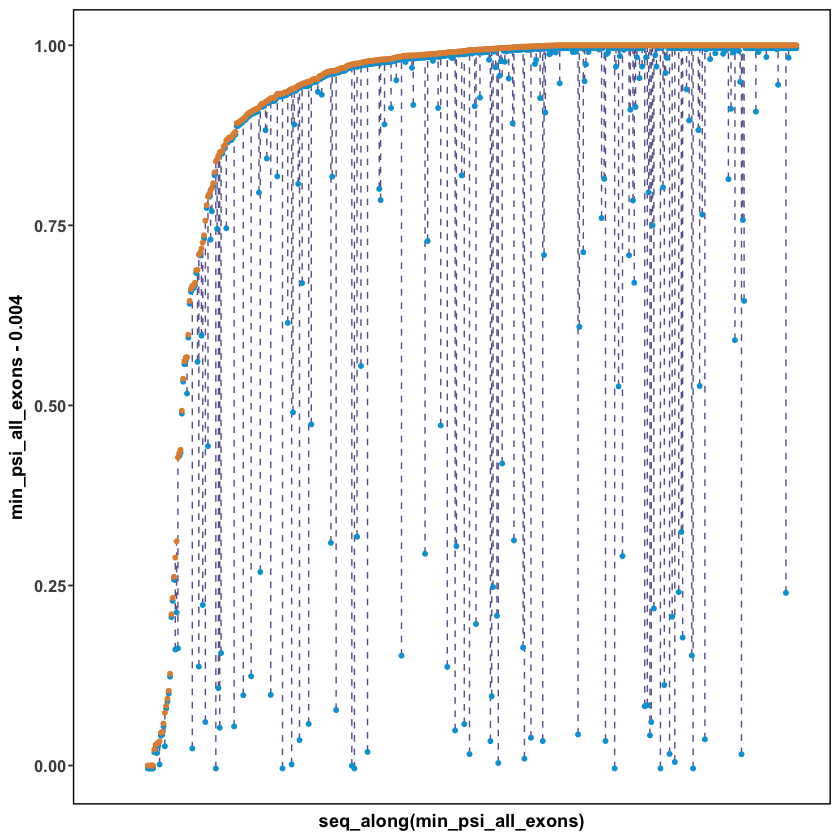

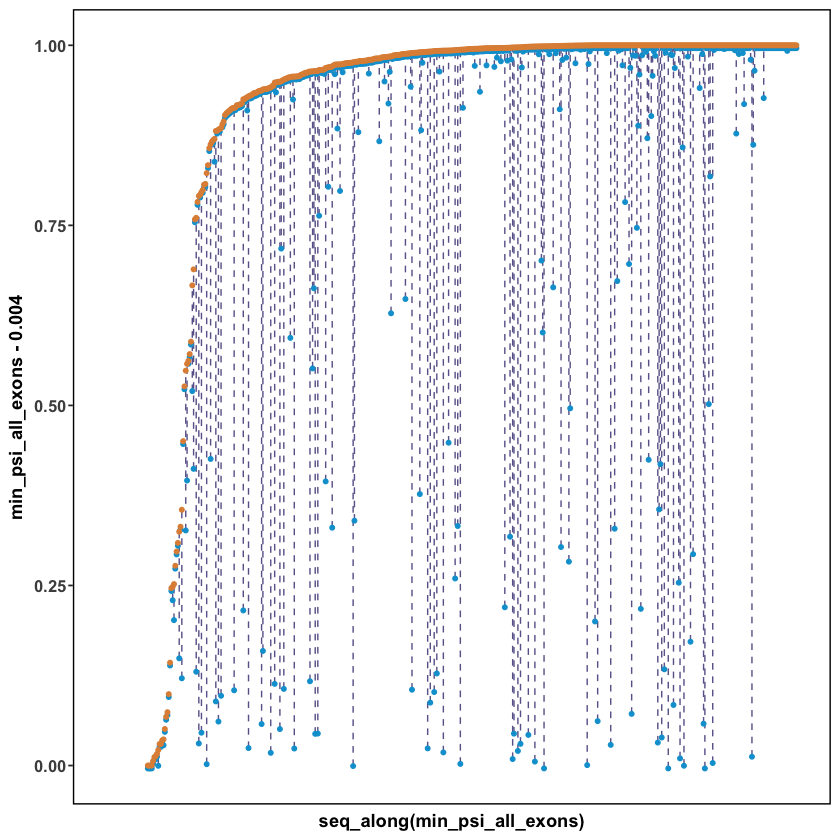

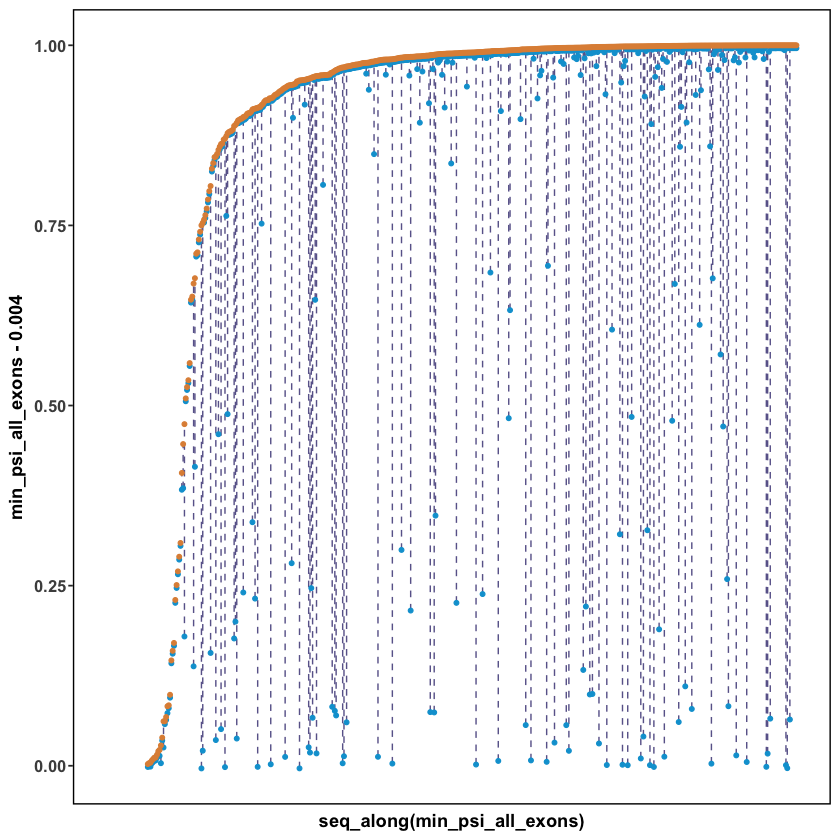

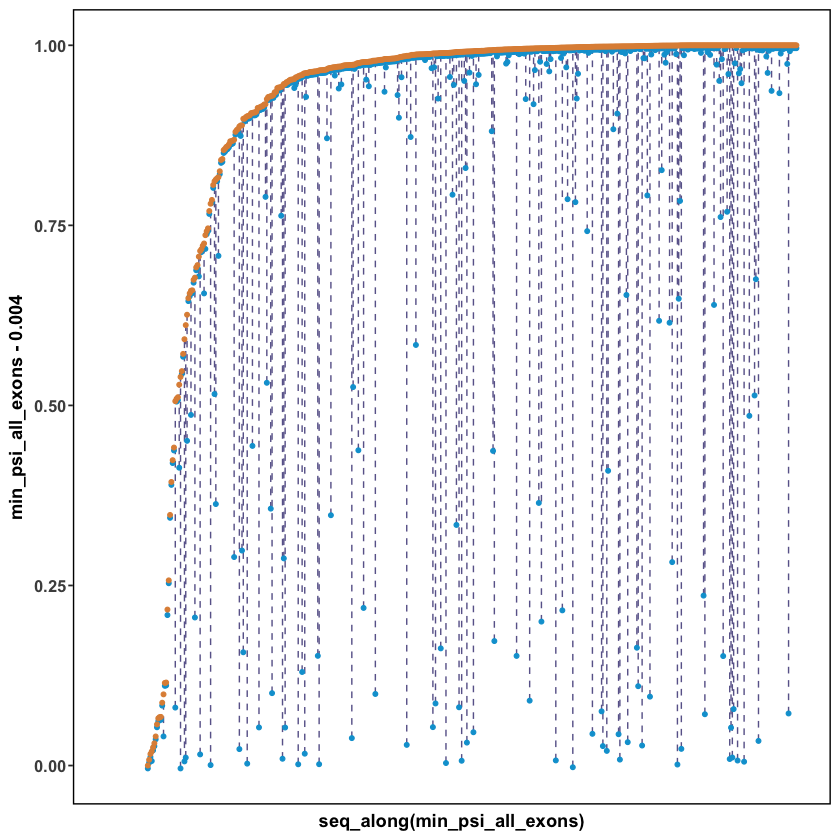

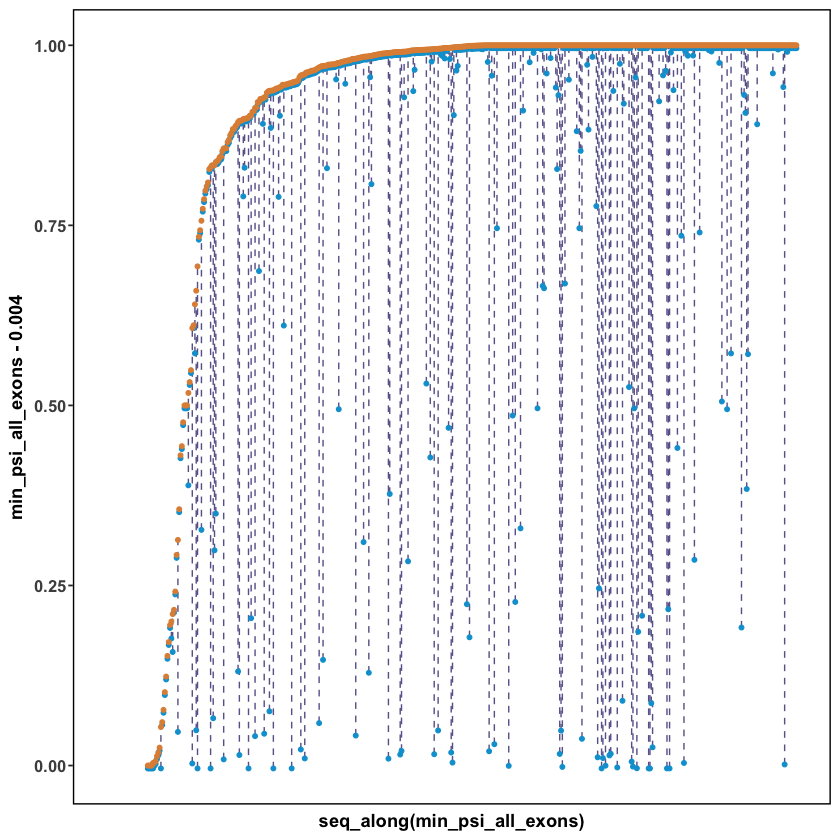

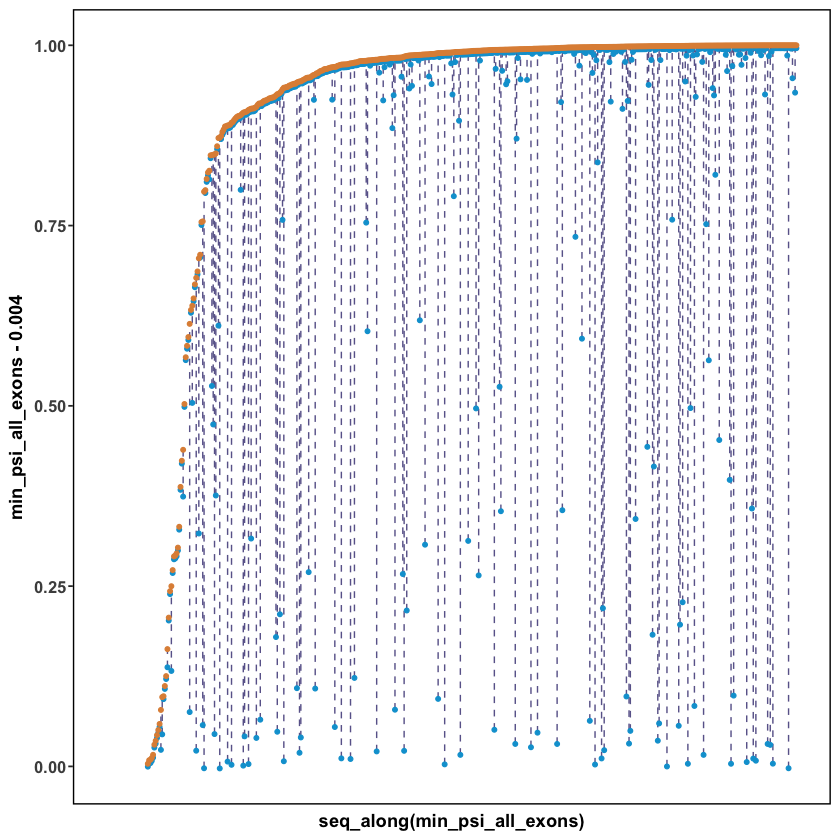

In [65]:
library(ggplot2)
library(dplyr)

for(psi_group in c('mean.fetal_neonatal.skeletal','mean.pediatric.skeletal','mean.adult.skeletal', 'mean.fetal_neonatal.cardiac','mean.pediatric.cardiac','mean.adult.cardiac')){
    data_for_vis <- cbind(clinvar.path_var.min_psi_only_gene_matched[,psi_group], clinvar.path_var.min_psi_path_exon_only[, psi_group]) %>% as.data.frame()
    colnames(data_for_vis) <- c("min_psi_all_exons", "min_psi_path_exons")

    #sort by min_psi_path_exons
    data_for_vis <- data_for_vis %>% arrange(min_psi_path_exons)

    # Create the plot using ggplot2
    waterfall_plot <- ggplot(data_for_vis) +
      # Dashed line segment
      geom_segment(aes(x = seq_along(min_psi_all_exons), xend = seq_along(min_psi_all_exons), y = min_psi_all_exons - 0.004, yend = min_psi_path_exons), color = col_sz[2], size = 0.4, linetype = "dashed") +
      # Point (circle) at the start of the line with color "red"
      geom_point(aes(x = seq_along(min_psi_all_exons), y = min_psi_all_exons - 0.004), color = col_sz[1], size = 1) +
      # Point (circle) at the end of the line with color "blue"
      geom_point(aes(x = seq_along(min_psi_all_exons), y = min_psi_path_exons), color = col_sz[3], size = 1) +
      theme_bw() +
      theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
            panel.border = element_rect(color = "black", size = 0.8),
            axis.text.y = element_text(size = 10, margin = margin(t = 0, r = 1, b = 0, l = 2), face = "bold"),
            axis.title = element_text(face = "bold")
      )+
      coord_cartesian(xlim = c(-30, dim(data_for_vis)[1]))

    save(waterfall_plot, file=paste0(Sys.getenv("psi_fig_tables_RData_dir"), "/waterfall_graph.", psi_group,  ".RData"))
    
    # Save the plot as a PDF file
    ggsave(paste0("waterfall_graph.", psi_group, ".pdf"), waterfall_plot, width = 7, height = 3.2)

    # Display the plot
    print(waterfall_plot)
}
